In [1]:
## Import relevant packages
import numpy as np
import matplotlib.pyplot as plt
import pyOptimalEstimation as pyOE
import os
import sys
import re
import seaborn as sns

## append paths
sys.path.append('C:/Users/Ida Olsen/Documents/Speciale_2022/scripts')
parrent_dir = "C:\\Users\\Ida Olsen\\Documents\\Speciale_2022"
sys.path.append(parrent_dir + '\\smrt')
sys.path.append(parrent_dir + '\\Ida_passive_SMRT\\Ida_passive_SMRT\\Code')

## Import SMRT packages
from smrt.permittivity.saline_snow import saline_snow_permittivity_scharien_with_stogryn95 as ssp
from smrt import make_ice_column, make_interface, make_snowpack, sensor_list
from smrt.core.globalconstants import PSU
from smrt import make_model
from smrt.interface.iem_fung92_brogioni10 import IEM_Fung92_Briogoni10
from smrt import SMRTError
from IPython.display import clear_output

## self made modules
from Snowpit_class import Snowpit_info
from roughness import roughness
from Make_plots import plot_freq
from forward_functions import forward_mean, forward
from prepare_inputs_OE import prepare_inputs, prepare_inputs_FYI
import prepare_inputs_OE as piO
from prepare_inputs_OE_sevlayer import prepare_inputs_sevlayer

In [2]:
def load_ref_data(site):
    """ Load data from landfree AMSR2 measurements co-located to CB pit sites"""
    data_dir = 'C:/Users/Ida Olsen/Documents/Speciale_2022/Ida_passive_SMRT/Ida_passive_SMRT/Code/' #import the path where the codes are
    os.chdir(data_dir)
    
    satdataH_landfree = np.load(data_dir + site + '_TBH_Landfree.npy')
    satdataV_landfree = np.load(site + '_TBV_Landfree.npy')
    satdataH_landfreeErr = np.load(site + '_TBH_Landfree_Err.npy')
    satdataV_landfreeErr = np.load(site + '_TBV_Landfree_Err.npy')
    
    data = np.zeros((2,len(satdataV_landfree)))
    dataErr = np.zeros((2,len(satdataV_landfree)))
    
    ## save data into matrix
    data[0,:] = satdataV_landfree.flatten()
    data[1,:] = satdataH_landfree.flatten()
    
    ## Errors
    dataErr[0,:] = satdataV_landfreeErr.flatten()
    dataErr[1,:] = satdataH_landfreeErr.flatten()
    
    return [data, dataErr]

In [22]:
## Calculate temperature profiles and fill snowpit class with observation data
from Functions_temp import Calc_temp_profiles
comb_info = Calc_temp_profiles(plot=False)

sites = ['AK1', 'AK2', 'AK3', 'AK4']
for site in sites:
    for i in range(len(sites)):
        if comb_info[i].site==site:
            s = comb_info[i]

In [23]:
## Pick a site to examine and load reference data for the site
sitenum = 3
s = comb_info[sitenum]
[dataAK2, dataErrAK2] = load_ref_data(s.site)

In [24]:
np.concatenate((dataAK2))[:10]

array([252.8, 255. , 255. , 254.7, 251.6, 229.7, 233.7, 235.4, 237. ,
       235.4])

In [25]:
## Define name of y-variables
y_vars = ["6V", "10V", "18V", "23V", "36V", "6H", "10H", "18H", "23H", "36H"] 
# Define values
y_obs  = np.concatenate((dataAK2))
## covariance matrix for TBs - 10X10 matrix
y_cov = np.diag([2,2,2,2,2,2,2,2,2,2])

# Define name of x-variables
x_vars = ["SD", "lex", "sal", "SIT"]
## prepare first guess, covariance matrix, upper and lower limits
[x_ap, x_cov, x_lowerLimit, x_upperLimit, x_info] = prepare_inputs(s , x_vars)

# print first guess info
print(x_info)
# print lower limit (unit m)
print(x_lowerLimit)
# print upper limit (unit m)
print(x_upperLimit)

{'SD cm': 10.0, 'lex mm': 0.17, 'sal PSU': 3.0, 'SIT cm': 200.0}
{'SD': 0.0, 'lex': 5e-05, 'sal': 0.0, 'SIT': 0.1}
{'SD': 1.0, 'lex': 0.0007, 'sal': 0.02, 'SIT': 6.0}


In [26]:
## define extra arguments to forward function
forwardKwArgs = {"variables": x_vars, "sitenum": sitenum}
# define the optimal estimation
oe = pyOE.optimalEstimation(
        x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_mean
        ,forwardKwArgs=forwardKwArgs
        ,x_lowerLimit=x_lowerLimit
        ,x_upperLimit=x_upperLimit
        )

In [27]:
# run the optimization and print outputs
oe.doRetrieval()
print(oe.x_op)

1.19 s, iteration 1, degrees of freedom: 1.15 of 4, converged (x-space):  0.225
1.74 s, iteration 2, degrees of freedom: 1.16 of 4, done.  0.003
SD     0.124997
lex    0.000178
sal    0.002608
SIT    1.999309
dtype: float64


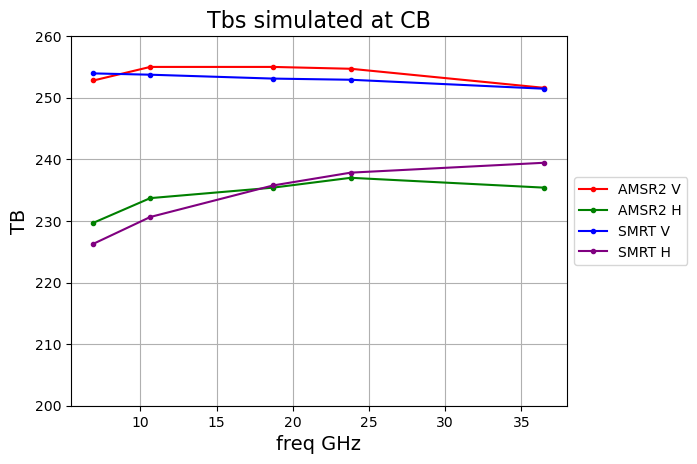

In [28]:
## Plots results
res = forward_mean(oe.x_op, x_vars, sitenum)
data_comb = np.zeros((4,5))
colors = ['r', 'g', 'b', 'purple']
labels = ['AMSR2 V', 'AMSR2 H', 'SMRT V', 'SMRT H']
data_comb[0:2,:] = dataAK2.reshape(2,5)
data_comb[2:4,:] = res.reshape(2,5)
plot_freq(s,data_comb, labels, colors, savefig=False)

# A SIMPLE MULTILAYER OE

In [35]:
### SEVERAL LAYERS
## Define name of y-variables
y_vars = ["6V", "10V", "18V", "23V", "36V", "6H", "10H", "18H", "23H", "36H"] 
# Define values
y_obs  = np.concatenate((dataAK2))
## covariance matrix for TBs - 10X10 matrix
y_cov = np.diag([2,2,2,2,2,2,2,2,2,2])

# Define name of x-variables
x_vars = ["SD", "lex"]
# number of layers in snowpack
nl_snow = 2
## prepare first guess, covariance matrix, upper and lower limits
[x_ap, x_cov, x_lowerLimit, x_upperLimit, x_info] = prepare_inputs_sevlayer(s , x_vars, nl_snow)

# print first guess info
print(x_info)
# print lower limit (unit m)
print(x_lowerLimit)
# print upper limit (unit m)
print(x_upperLimit)

{'SD0cm': 5.0, 'SD1cm': 5.0, 'lex0mm': 0.17, 'lex1mm': 0.17}
{'SD0': 0.0, 'SD1': 0.0, 'lex0': 5e-05, 'lex1': 5e-05}
{'SD0': 0.5, 'SD1': 0.5, 'lex0': 0.0007, 'lex1': 0.0007}


In [36]:
## define extra arguments to forward function
x_vars = list(x_upperLimit.keys())
forwardKwArgs = {"variables": x_vars, "nl_snow": nl_snow, "sitenum": sitenum}
# define the optimal estimation
oe = pyOE.optimalEstimation(
        x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward
        ,forwardKwArgs=forwardKwArgs
        ,x_lowerLimit=x_lowerLimit
        ,x_upperLimit=x_upperLimit
        )
print(x_info)

{'SD0cm': 5.0, 'SD1cm': 5.0, 'lex0mm': 0.17, 'lex1mm': 0.17}


In [37]:
# run the optimization and print outputs
oe.doRetrieval(maxIter=10, maxTime=1000.0)
print(oe.x_op)

1.35 s, iteration 1, degrees of freedom: 1.24 of 4, not converged (x-space):  6.519
1.97 s, iteration 2, degrees of freedom: 1.22 of 4, converged (x-space):  0.030
2.59 s, iteration 3, degrees of freedom: 1.22 of 4, done.  0.003
SD0     0.068242
SD1     0.029039
lex0    0.000173
lex1    0.000171
dtype: float64


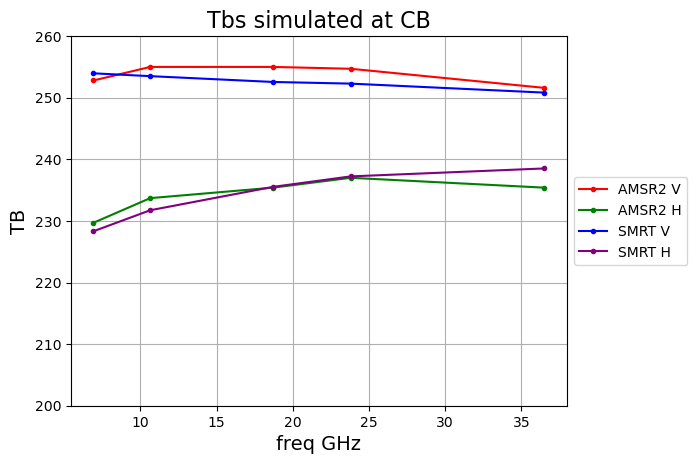

In [38]:
## Plots results
res = forward(oe.x_op, x_vars, nl_snow, sitenum)
data_comb = np.zeros((4,5))
colors = ['r', 'g', 'b', 'purple']
labels = ['AMSR2 V', 'AMSR2 H', 'SMRT V', 'SMRT H']
data_comb[0:2,:] = dataAK2.reshape(2,5)
data_comb[2:4,:] = res.reshape(2,5)

plot_freq(s, data_comb, labels, colors, savefig=False)
# clear_output(wait=False)

# Convergence test for SD start guess - nl_snow=1

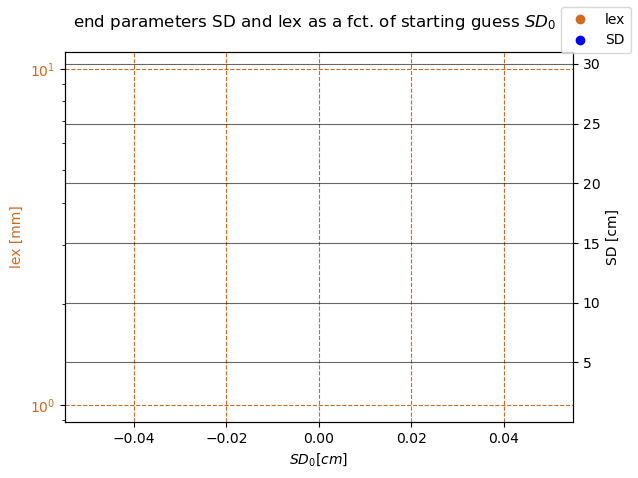

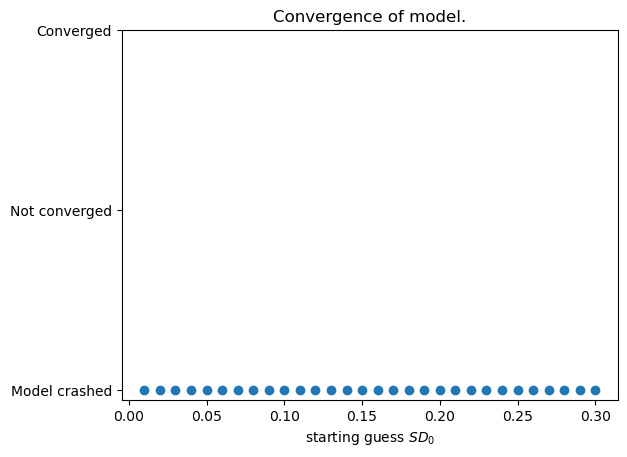

In [39]:
## Define name of y-variables
y_vars = ["6V", "10V", "18V", "23V", "36V", "6H", "10H", "18H", "23H", "36H"] 
# Define values
y_obs  = np.concatenate((dataAK2))
## covariance matrix for TBs - 10X10 matrix
y_cov = np.diag([2,2,2,2,2,2,2,2,2,2])
# Define name of x-variables
x_vars = ["SD", "lex"]
## define extra arguments to forward function
forwardKwArgs = {"variables": x_vars, "sitenum": sitenum}
## prepare first guess, covariance matrix, upper and lower limits
[x_app, x_cov, x_lowerLimit, x_upperLimit, x_info] = prepare_inputs(s , x_vars)
# print first guess info
print(x_info)

max_it = 15 # maximum number of iterations in optimal estimation

## check SD convergence
start = 0.01 # start value for SD
stop = 0.31 # stop value for SD
stepsize = 0.01 # step size for SD
N = np.round((stop-start)/stepsize) # The amount of iterations each loop will do
print(N)

def iterate_SD(start, stop, stepsize, plots = False):

    conv = 0
    SD  = np.array([])
    LEX = np.array([])
    conv = np.array([])
    xx = np.array([])

    for i in np.arange(start, stop, stepsize):
        try:
            sd = i
            lex = x_app[1]
            print(sd)
            # first guess for X
            x_ap = [sd, lex]
            # create optimal estimation object
            oe = pyOE.optimalEstimation(
                x_vars, x_ap, x_cov, y_vars, y_obs, y_cov, forward_mean,
                forwardKwArgs=forwardKwArgs
                ,x_lowerLimit=x_lowerLimit, 
                x_upperLimit=x_upperLimit
                )

            # run the retrieval
            oe.doRetrieval(maxIter=max_it, maxTime=1000.0)

            if oe.converged == True:
                SD_end = oe.x_op[0]
                lex_end = oe.x_op[1]
                SD = np.append(SD, SD_end)
                LEX = np.append(LEX, lex_end)
                xx = np.append(xx, i)

            conv = np.append(conv, oe.converged)
        except:
            print("Did not converge")
            conv = np.append(conv, -1)

    clear_output(wait=False)
    if plots == True:
        fig, ax1 = plt.subplots()
        fig.suptitle('end parameters SD and lex as a fct. of starting guess $SD_0$')
        ax1.set_xlabel('$SD_0 [cm]$')
        ax1.set_ylabel('lex [mm]', color='chocolate')
        ax1.plot(xx*1e2, LEX*1e3, 'o', label='lex', color='chocolate')
        ax1.tick_params(axis='y', labelcolor='chocolate')
        ax1.grid(color='chocolate', linestyle = '--')
        ax1.set_yscale('log')
        ax2 = ax1.twinx()
        ax2.set_ylabel('SD [cm]', color = 'black')
        ax2.plot(xx*1e2, SD*1e2, 'o', label='SD', color='blue')
        #ax2.plot(xx, H, 'o', label='H', color='green')
        #ax2.tick_params(axis='y', labelcolor='black')
        ax2.grid(color = 'black', alpha = 0.6)
        ax2.set_ylim([start,stop*1e2])
        fig.tight_layout()
        fig.legend()

        plt.figure()
        plt.plot(np.arange(start, stop, stepsize), conv, 'o')
        plt.xlabel('starting guess $SD_0$')
        plt.title('Convergence of model.')
        plt.yticks([-1, 0,1], ['Model crashed', 'Not converged', 'Converged'])

    return np.sum(conv[conv > -0.5])

iterate_SD(start, stop, stepsize, plots=True)
plt.show()